In [ ]:
# -*- coding: utf-8 -*-

"""
This software is part of GPU Ocean. 
Copyright (C) 2019 SINTEF Digital

This notebook is used to show the individual steps of the ETKF for an ocean ensemble.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
"""


import sys, os, datetime, time, shutil
from importlib import reload 
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib import gridspec as gridspec

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

current_dir = os.getcwd()

if os.path.isdir(os.path.abspath(os.path.join(current_dir, '../../SWESimulators'))):
        sys.path.insert(0, os.path.abspath(os.path.join(current_dir, '../../')))

from SWESimulators import IPythonMagic
from SWESimulators import BaseOceanStateEnsemble, OceanNoiseEnsemble, CDKLM16 
from SWESimulators import Common
from SWESimulators import DataAssimilationUtils as dautils



In [ ]:
%cuda_context_handler gpu_ctx
%setup_logging --out enkf_gpu.log --file_level 15

Console logger using level INFO
File logger using level Level 15 to enkf_gpu.log
Python version 3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 01:53:57) [MSC v.1916 64 bit (AMD64)]


# Set up an instance 

OceanNoiseEnsemble using CDKLM16-Simulators

In [ ]:
# DEFINE PARAMETERS

sim_args = {
    "gpu_ctx": gpu_ctx,
    "nx": 60, "ny": 60,
    "dx": 4.0, "dy": 4.0,
    "dt": 0.05,
    "g": 9.81,
    "f": 0.05,
    "coriolis_beta": 0.0,
    "r": 0.0,
    "rk_order": 2,
    "small_scale_perturbation_amplitude": None,
    "write_netcdf": False, 
    "small_scale_perturbation": True,
    "small_scale_perturbation_interpolation_factor": 3,
    "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
}

ghosts = np.array([2,2,2,2]) # north, east, south, west
validDomain = np.array([2,2,2,2])


dataShape = (sim_args["ny"] + ghosts[0]+ghosts[2], 
             sim_args["nx"] + ghosts[1]+ghosts[3])
dataShapeHi = (sim_args["ny"] + ghosts[0]+ghosts[2]+1, 
             sim_args["nx"] + ghosts[1]+ghosts[3]+1)

sim_args["eta0"] = np.zeros(dataShape, dtype=np.float32, order='C');
sim_args["hv0"] = np.zeros(dataShape, dtype=np.float32, order='C');
sim_args["hu0"] = np.zeros(dataShape, dtype=np.float32, order='C');
waterDepth = 10.0
sim_args["H"] = np.ones(dataShapeHi, dtype=np.float32, order='C')*waterDepth


if 'sim' in globals():
    sim.cleanUp()
if 'ensemble' in globals():
    ensemble.cleanUp()
if 'iewpfOcean' in globals():
    iewpfOcean.cleanUp()
    
sim_args["small_scale_perturbation_amplitude"] = np.sqrt(sim_args["dt"])*0.5*sim_args["f"]/(sim_args["g"]*waterDepth)
sim_args["small_scale_perturbation_amplitude"] *= sim_args["small_scale_perturbation_interpolation_factor"]
print ("q0: ", sim_args["small_scale_perturbation_amplitude"])
print ("[f, g, H, dt]", [sim_args["f"], sim_args["g"], waterDepth, sim_args["dt"]])
print ("(nx, ny): ", (sim_args["nx"], sim_args["ny"]))

reload(CDKLM16)
reload(BaseOceanStateEnsemble)
reload(OceanNoiseEnsemble)
reload(dautils)

sim = CDKLM16.CDKLM16(**sim_args)
sim.perturbState(q0_scale=100)
    
ensemble_args = {
    "gpu_ctx": gpu_ctx,
    "numParticles": 100,
    "num_drifters": 2,
    "sim": sim,
    "observation_type": dautils.ObservationType.StaticBuoys,
    "buoys_positions" : [[120.0,120.0],[60.0,60.0]],
    "observation_variance": 0.5**2,
    "initialization_variance_factor_ocean_field" : 25.0
}

ensemble = OceanNoiseEnsemble.OceanNoiseEnsemble(**ensemble_args)

max_dt = ensemble.findLargestPossibleTimeStep()
print ("max_dt: ", max_dt)

print ("Ready!")

q0:  0.00017095320928897472
[f, g, H, dt] [0.05, 9.81, 10.0, 0.05]
(nx, ny):  (60, 60)
max_dt:  0.09038609266281128
Ready!


# Run Simulation until Observation Time

In [ ]:
t = 100*sim_args["dt"]
ensemble.step(t)

print("Ready!")

Ready!


# Book keeping

In [ ]:
# Deactivating some particles for testing
ensemble.particlesActive[2]=False
ensemble.particlesActive[7]=False

In [ ]:
# Size of ensemble
N_e = ensemble.getNumParticles()
N_e_active = ensemble.getNumActiveParticles()

# Number of observers
N_d = ensemble.getNumDrifters()

# particle properties before EnKF analysis phase
observedParticles_pre = ensemble.observeParticles()
innovationNorms_pre = ensemble.getInnovationNorms()

# rmse values before EnKF analysis phase
ensemble.getEnsembleVarAndRMSEUnderDrifter(t)
rmse_eta_pre = ensemble.rmseUnderDrifter_eta
rmse_hu_pre  = ensemble.rmseUnderDrifter_hu
rmse_hv_pre  = ensemble.rmseUnderDrifter_hv


# Hidden ETKF

In [ ]:
import ETKFOcean
reload(ETKFOcean)

etkf = ETKFOcean.ETKFOcean(ensemble)

etkf.ETKF(ensemble)

# Plotting Utils

In [ ]:
def _fillPolarPlot(ax, ensemble, observedParticles, alpha, printInfo=False):
    """
    Internal utility function for plotting current under a drifter as a polar plot.
    """
    max_r = 0
    observedParticlesSingleDrifter = observedParticles[:, 0, :]
    if printInfo: print("observedParticlesSingleDrifter: \n" +str(observedParticlesSingleDrifter))
    for p in range(ensemble.getNumParticles()):
        u, v = observedParticlesSingleDrifter[p,0], observedParticlesSingleDrifter[p,1]
        r = np.sqrt(u**2 + v**2)
        max_r = max(max_r, r)
        theta = np.arctan(v/u)
        if (u < 0):
            theta += np.pi
        arr1 = plt.arrow(theta, 0, 0, r, alpha = alpha, \
                         length_includes_head=True, \
                         edgecolor = 'green', facecolor = 'green', zorder = 5)

    obs_u = ensemble.observeTrueState()[0, 2]
    obs_v = ensemble.observeTrueState()[0, 3]
    if printInfo: print("observedTrueState: " + str((obs_u, obs_v)))
    obs_r = np.sqrt(obs_u**2 + obs_v**2)
    max_r = max(max_r, obs_r)
    obs_theta = np.arctan(obs_v/obs_u)
    if (obs_u < 0):
        obs_theta += np.pi
    arr1 = plt.arrow(obs_theta, 0, 0, obs_r, alpha = 0.5,\
                     length_includes_head=True, \
                     edgecolor = 'red', facecolor = 'red', zorder = 5)

    ax.set_rmax(max_r*1.2)
    plt.grid(True)
    plt.title("Momentum observations from drifter")


def _fillHistPlot(ax, ensemble, innovationNorms, alpha, printInfo=False):
    if printInfo: print("innovation norms: " + str(innovationNorms))
    obs_var = ensemble.getObservationVariance()
    range_x = np.sqrt(obs_var)*10
    ax.hist(innovationNorms, bins=30, facecolor='green', \
                range=(0, range_x), alpha=alpha,\
                density=True, label="particle innovations (norm)")
    plt.title("Innovation norms from drifter")


def plotVelocityInfoBeforeAndAfterDA(ensemble, observedParticles, innovationNorms, observedParticles_pre=None, innovationNorms_pre=None, title=None) :

    # Initialize File
    fig = None
    plotRows = 2
    fig = plt.figure(figsize=(10,6))
    gridspec.GridSpec(plotRows, 3)

    # PLOT POSITIONS OF PARTICLES AND OBSERVATIONS
    ax = plt.subplot2grid((plotRows,3), (0,0), polar=True)
    _fillPolarPlot(ax, ensemble, observedParticles, 0.5, printInfo=False)
    if observedParticles_pre is not None:
        _fillPolarPlot(ax, ensemble, observedParticles_pre, 0.1, printInfo=False)

    # PLOT DISCTRIBUTION OF PARTICLE DISTANCES AND THEORETIC OBSERVATION PDF
    ax0 = plt.subplot2grid((plotRows,3), (0,1), colspan=2)
    _fillHistPlot(ax0, ensemble, innovationNorms, 0.5, printInfo=False)
    if innovationNorms_pre is not None:
        _fillHistPlot(ax0, ensemble, innovationNorms_pre, 0.1, printInfo=False)

    if title is not None:
        plt.suptitle(title, fontsize=16)
    plt.tight_layout()

# ------------------------------------------------------------------------

def _fillHistComponentPlot(ax, ensemble, observedParticles, component, alpha, markTruth=False, subtitle=None):
    true_component = ensemble.observeTrueState()[0,2+component]
    range_x = 5
    ax.hist(observedParticles[:,0][:,component], bins=50, facecolor='green', \
        range=(true_component-range_x,true_component+range_x), \
        alpha=alpha, density=True)
    if markTruth is True:
        ax.axvline(true_component, color='green', linestyle='dashed', linewidth=1)
    if subtitle is not None:
        ax.title.set_text(subtitle)


def plotVelocityComponentInfoBeforeAndAfterDA(ensemble, observedParticles, observedParticles_pre=None, title=None):
    fig = None
    fig, axs = plt.subplots(1, 2, figsize=(10,3))
    # hist for hu
    subtitle = "$hu$ distribution for ensemble"
    _fillHistComponentPlot(axs[0], ensemble, observedParticles, 0, 0.5, markTruth=True, subtitle=subtitle)
    if observedParticles_pre is not None:
        _fillHistComponentPlot(axs[0], ensemble, observedParticles_pre, 0, 0.1)
    # hist for hv
    subtitle = "$hv$ distribution for ensemble"
    _fillHistComponentPlot(axs[1], ensemble, observedParticles, 1, 0.5, markTruth=True, subtitle=subtitle)
    if observedParticles_pre is not None:
        _fillHistComponentPlot(axs[1], ensemble, observedParticles_pre, 1, 0.1)



# Plot circular diagram and histogram

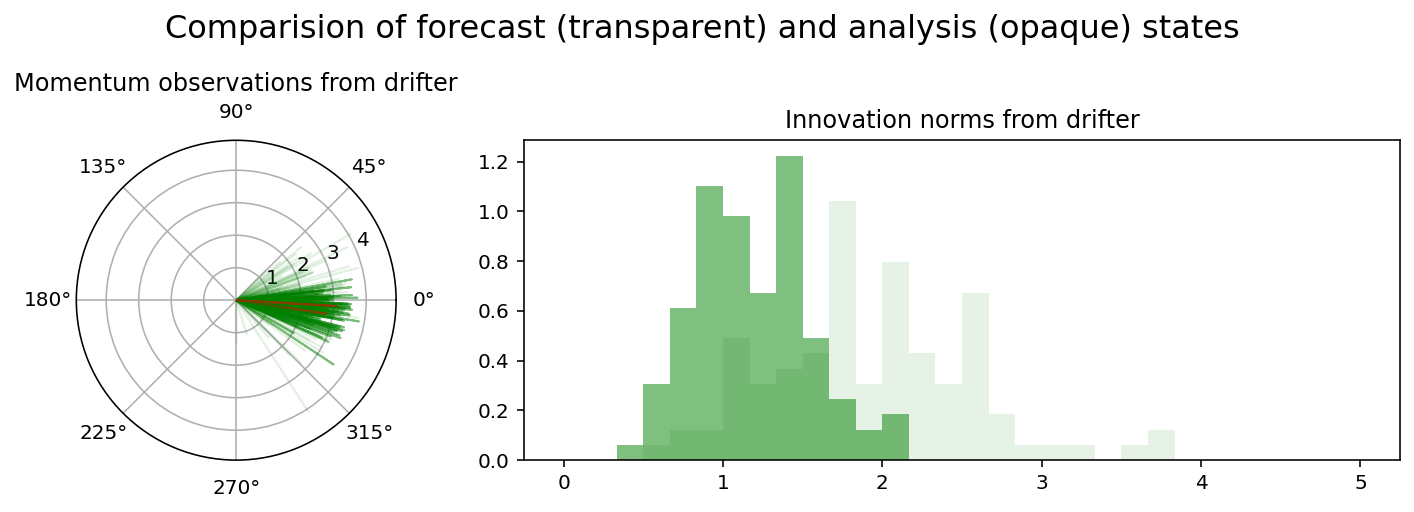

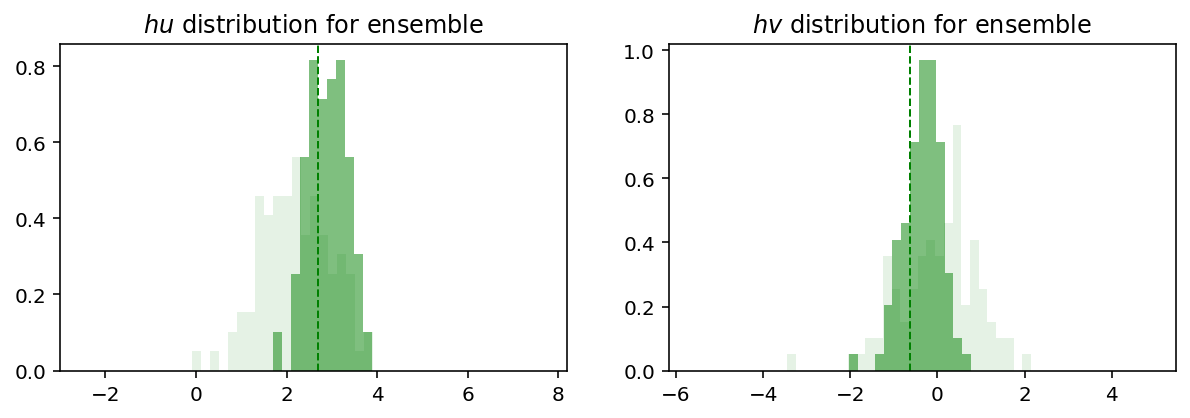

In [ ]:
# Download Data from Simulators
observedParticles = ensemble.observeParticles()
innovationNorms = ensemble.getInnovationNorms()

title = "Comparision of forecast (transparent) and analysis (opaque) states"
plotVelocityInfoBeforeAndAfterDA(ensemble, observedParticles, innovationNorms, observedParticles_pre, innovationNorms_pre, title)

title = "Comparision of forecast (transparent) and analysis (opaque) states for velocity components"
plotVelocityComponentInfoBeforeAndAfterDA(ensemble, observedParticles, observedParticles_pre, title)

## Compare norms of particles before and after assimilation 

In [ ]:
for e in range(N_e):
    norm_pre = np.sqrt(np.sum(observedParticles_pre[e,:]**2))
    norm = np.sqrt(np.sum(observedParticles[e,:]**2))
    print("norm before EnKF: ", format(norm_pre, ".6f"), " and norm after EnKF: ", format(norm, ".6f"))

norm before EnKF:  5.156656  and norm after EnKF:  5.329365
norm before EnKF:  3.792087  and norm after EnKF:  4.497311
norm before EnKF:  nan  and norm after EnKF:  nan
norm before EnKF:  6.038419  and norm after EnKF:  5.595907
norm before EnKF:  5.377506  and norm after EnKF:  5.578727
norm before EnKF:  6.752440  and norm after EnKF:  6.227058
norm before EnKF:  6.758299  and norm after EnKF:  6.166340
norm before EnKF:  nan  and norm after EnKF:  nan
norm before EnKF:  4.950639  and norm after EnKF:  5.352548
norm before EnKF:  4.724698  and norm after EnKF:  5.234071
norm before EnKF:  4.980854  and norm after EnKF:  5.177503
norm before EnKF:  5.988985  and norm after EnKF:  5.549280
norm before EnKF:  5.395940  and norm after EnKF:  5.593858
norm before EnKF:  5.794121  and norm after EnKF:  5.668947
norm before EnKF:  3.162826  and norm after EnKF:  4.401933
norm before EnKF:  5.193522  and norm after EnKF:  5.386616
norm before EnKF:  4.371461  and norm after EnKF:  4.948690


# RMSE Analysis

In [ ]:
# rmse values before EnKF analysis phase
ensemble.getEnsembleVarAndRMSEUnderDrifter(t)
rmse_eta = ensemble.rmseUnderDrifter_eta
rmse_hu  = ensemble.rmseUnderDrifter_hu
rmse_hv  = ensemble.rmseUnderDrifter_hv

In [ ]:
print("Comparison of RMSE before and after analysis phase\n")
print("RMSE for eta before: ", rmse_eta[0], " and after: ", rmse_eta[1])
print("RMSE for hu  before: ", rmse_hu[0], " and after: ", rmse_hu[1])
print("RMSE for hv  before: ", rmse_hv[0], " and after: ", rmse_hv[1])

Comparison of RMSE before and after analysis phase

RMSE for eta before:  0.027127794309835564  and after:  0.04054793904314925
RMSE for hu  before:  0.9793782160392589  and after:  0.8627137485746909
RMSE for hv  before:  0.8732033204589037  and after:  1.0812029138398842
